No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


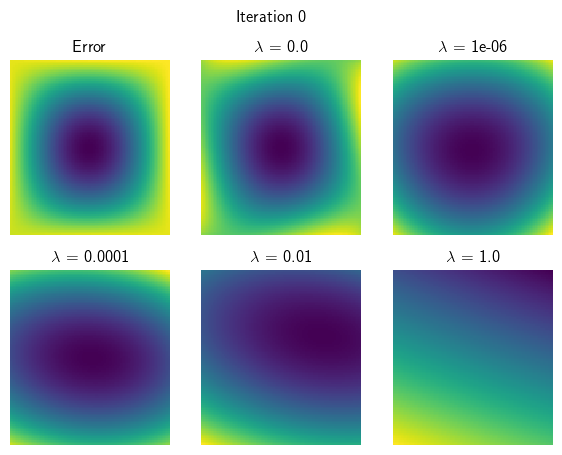

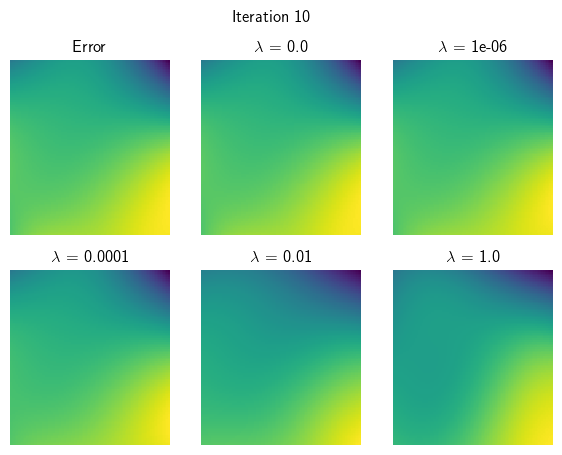

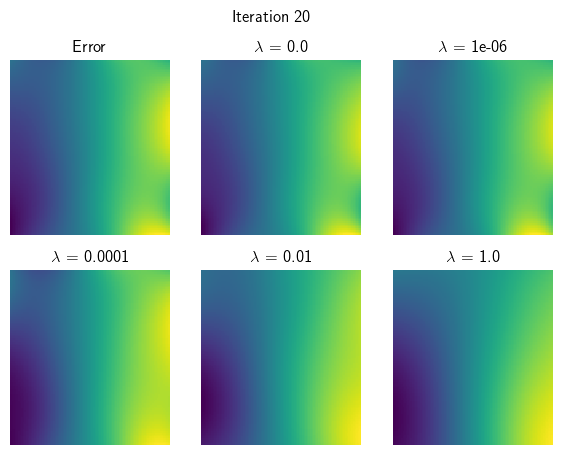

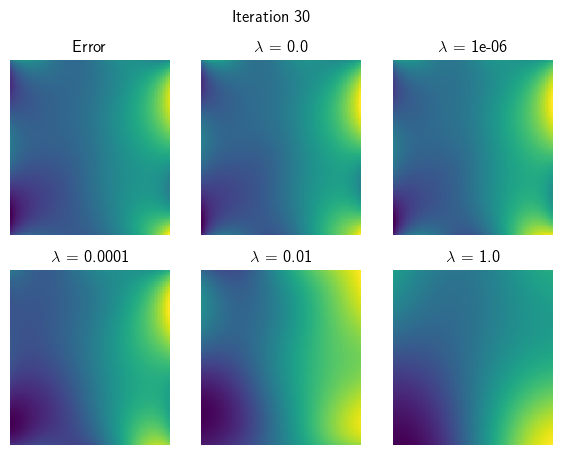

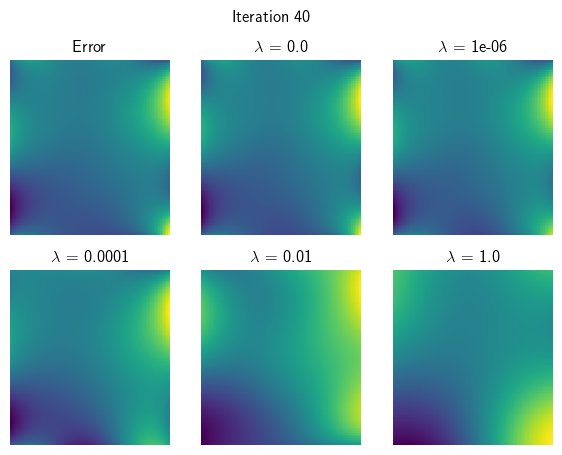

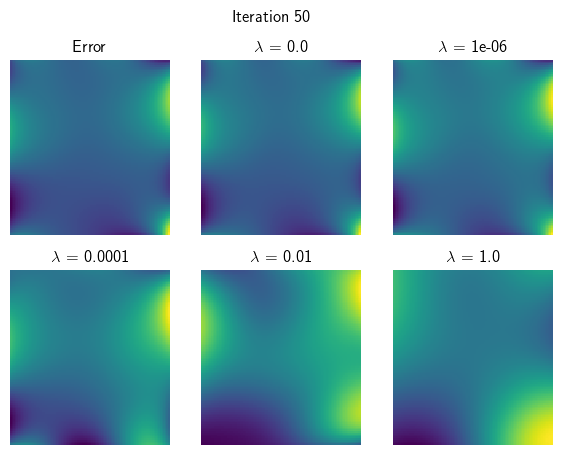

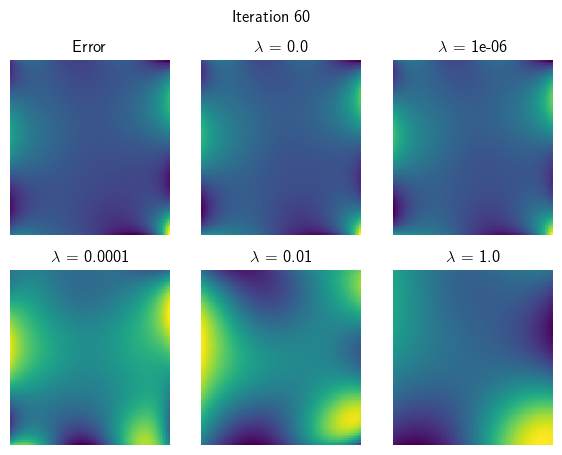

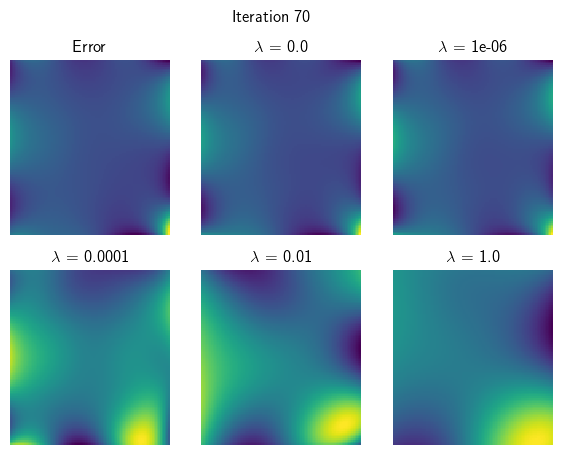

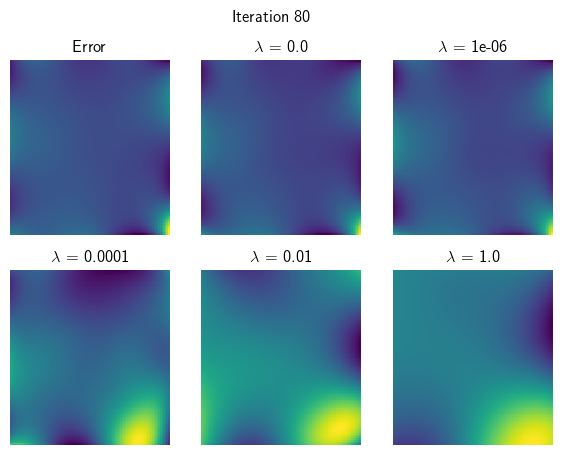

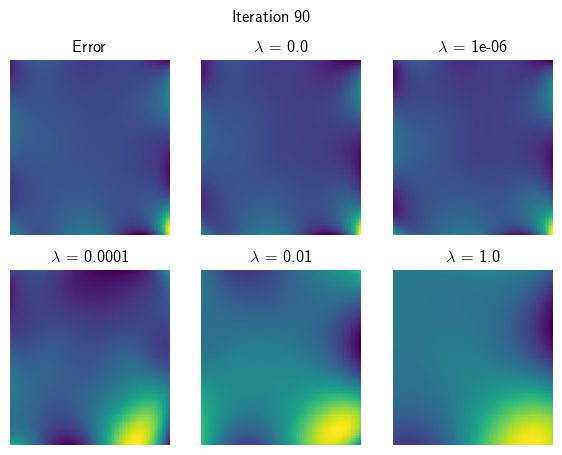

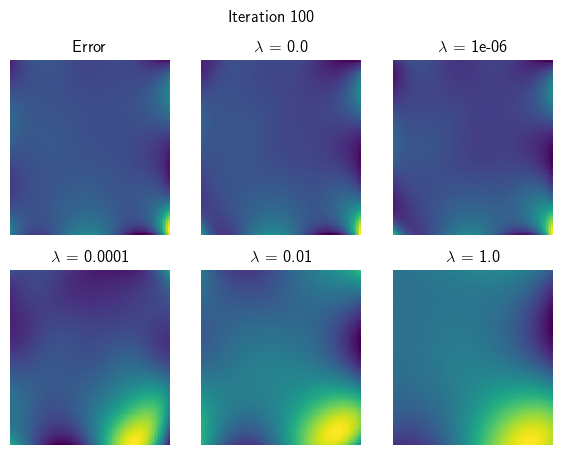

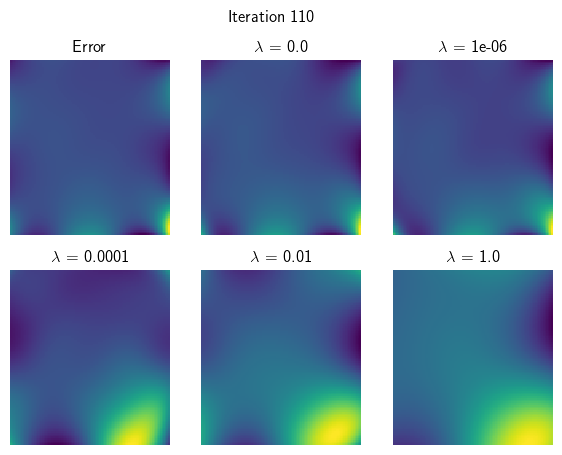

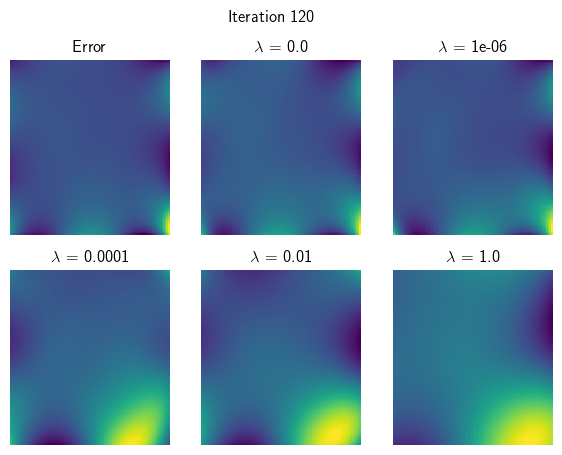

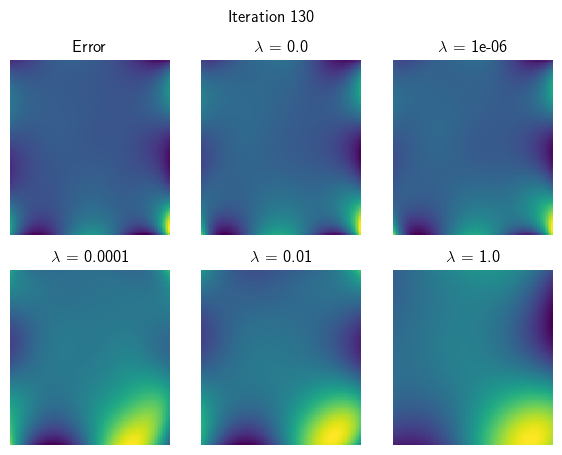

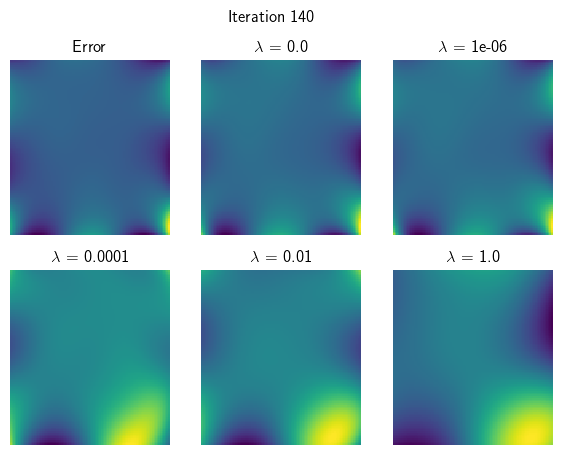

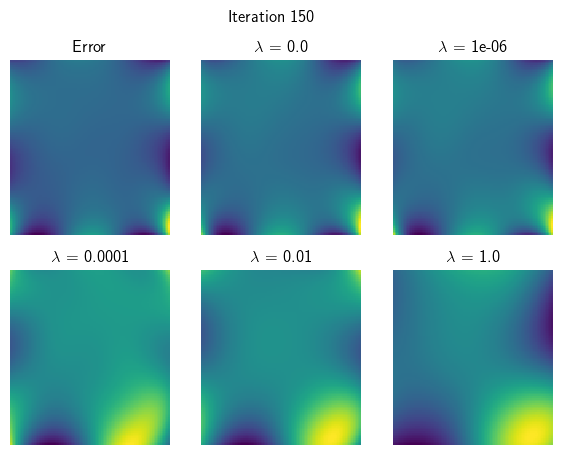

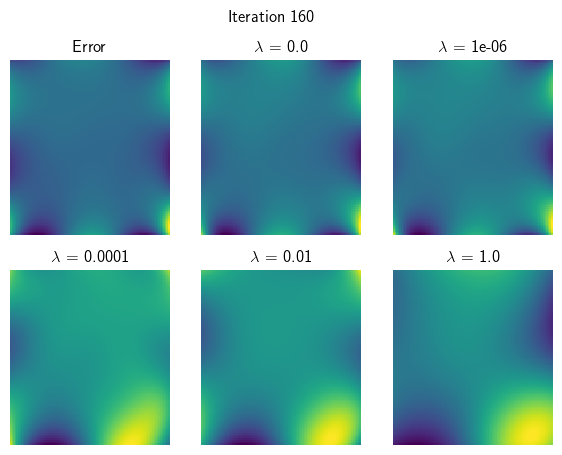

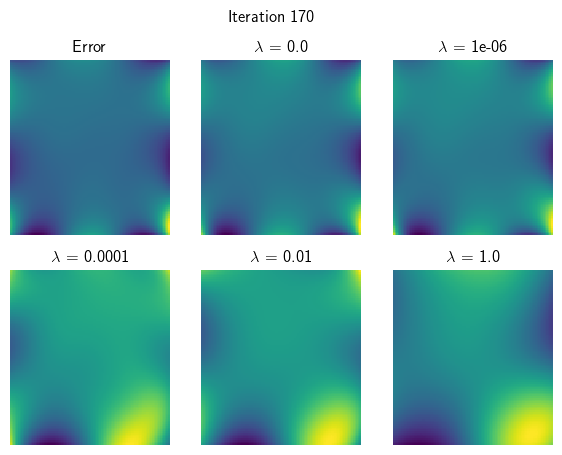

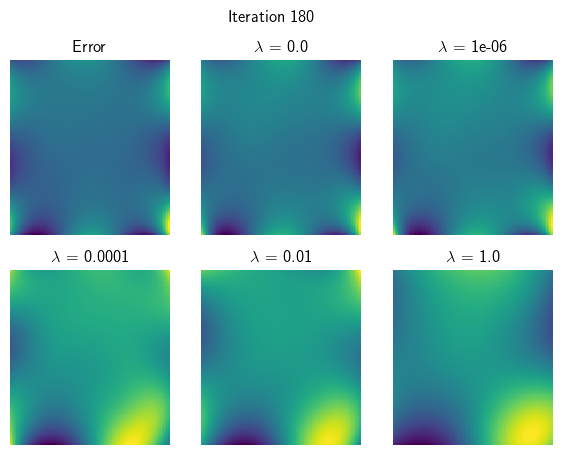

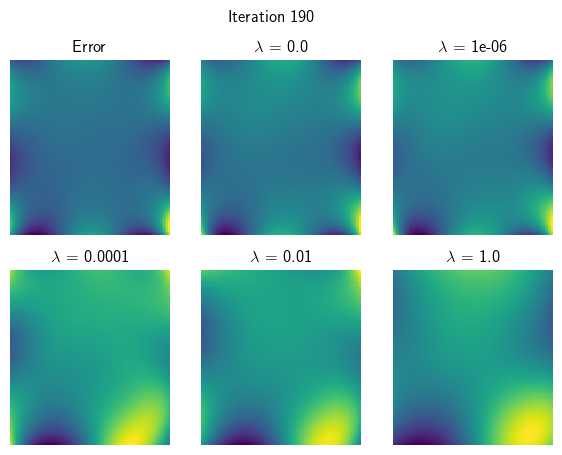

In [1]:
# export XLA_FLAGS=--xla_gpu_force_compilation_parallelism=1
import jax
from jax.scipy.sparse.linalg import cg
import jax.numpy as jnp
from jax import random, grad, vmap, jit
from jax.numpy.linalg import lstsq
import matplotlib.pyplot as plt

import natgrad.mlp as mlp
from natgrad.domains import Square
from natgrad.domains import SquareBoundary, Polygon
from natgrad.integrators import RandomIntegrator, DeterministicIntegrator, EvolutionaryIntegrator
from natgrad.derivatives import laplace
from natgrad.inner import model_laplace, model_identity
from natgrad.gram import gram_factory, nat_grad_factory, nat_grad_factory_generic
from natgrad.utility import grid_line_search_factory
from natgrad.plotting import plot_2d_func, plot_2d_funcs
from natgrad.linalg import sherman_morrison
from jaxopt import LevenbergMarquardt
from natgrad.plotting import remove_axes

jax.config.update("jax_enable_x64", True)

import matplotlib
matplotlib.rcParams['text.usetex'] = True

# random seed
seed = 2
freq = 1.



solver=lambda A, b: lstsq(A, b, rcond=1e-10)[0]

# domains
interior = Square(1.) #Polygon(jnp.array([[0,0], [1,0], [0,1]])) # S
boundary = interior.boundary()

# integrators
key = random.PRNGKey(seed)

interior_integrator = RandomIntegrator(interior, key, 50)
boundary_integrator = RandomIntegrator(boundary, key, 50)
eval_integrator = RandomIntegrator(interior, key, 200)

# model
activation = lambda x : jnp.tanh(x)
layer_sizes = [2, 32, 1]
params = mlp.init_params(layer_sizes, random.PRNGKey(seed))
model = mlp.mlp(activation)
v_model = vmap(model, (None, 0))

# 

# solution
@jit
def u_star(xy): return jnp.sin(freq * jnp.pi * xy[0]) * jnp.sin(freq * jnp.pi * xy[1])

# rhs
@jit
def f(xy):
    return 2. * (freq * jnp.pi)**2 * u_star(xy)

# gramians
gram_bdry = gram_factory(model = model, trafo = model_identity, integrator = boundary_integrator)
gram_laplace = gram_factory(model = model, trafo = model_laplace, integrator = interior_integrator)

# trick to get the signature (params, v_x) -> v_residual
_residual = lambda params: laplace(lambda x: model(params, x))
residual = lambda params, x: (_residual(params)(x) + f(x))**2.
v_residual =  jit(vmap(residual, (None, 0)))

# loss
@jit
def interior_loss(params):
    return interior_integrator(lambda x: v_residual(params, x))

@jit
def boundary_loss(params):
    boundary_integrand = lambda x: model(params, x)**2
    return boundary_integrator(vmap(boundary_integrand, (0)))

@jit
def loss(params):
    return interior_loss(params) + boundary_loss(params)

# errors
error = lambda x: model(params, x) - u_star(x)
v_error = vmap(error, (0))
v_error_abs_grad = vmap(lambda x: jnp.dot(grad(error)(x), grad(error)(x))**0.5)

def l2_norm(f, integrator):
    return integrator(lambda x: (f(x))**2)**0.5    


@jit
def gram(params, eps=0.):
    gram_ = gram_laplace(params) + gram_bdry(params)
    grad_, _ =  jax.flatten_util.ravel_pytree(grad(loss)(params))
    grad_norm_ = jnp.linalg.norm(grad_)
    return gram_ + eps * jnp.eye(gram_.shape[0]) * grad_norm_ ** 0.5
    #return gram_ + eps * jnp.eye(gram_.shape[0]) 
    
def update_step(x, param, natgrad_flat):
    return jax.jvp(lambda param: model(param, x), (param,), (natgrad_flat,))[1]

def wrap(func, *args):
    return jit(vmap(lambda x: func(x, *args), (0)))


eps_vals = [0., 1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1.]
iters = list(range(0, 200, 10))


eps_vals = [0., 1e-6, 1e-4, 1e-2, 1.]
#iters = [0, 100, 200, 210]
# natural gradient
for idx, i in enumerate(iters):
    data = jnp.load(f"/home/emastr/phd/NaturalGradientTraining/data/state_ENG_{i}.npy", allow_pickle=True).item()
    
    params = data["params"]
    grads = grad(loss)(params)
    
    
    fig = plt.figure(figsize=(7,5))
    fig.suptitle(f"Iteration {i}")
    plt.subplot(2, 3, 1)
    plt.title(f"Error")
    plot_2d_func(wrap(lambda x, par: (model(par, x) - u_star(x)), params), interior, 100, ax=plt.gca())
    plt.axis('off')
    
    for j, eps in enumerate(eps_vals):    
        nat_grad = nat_grad_factory_generic(gram, solver, eps=eps)
        nat_grads = nat_grad(params, grads)

        plt.subplot(2, 3, j+2)
        plt.title(f"$\lambda$ = {eps}")
        plot_2d_func(wrap(update_step, params, nat_grads), interior, 100, ax=plt.gca())
        plt.axis('off')
        
    fig.savefig(f"/home/emastr/phd/NaturalGradientTraining/experiments/alignment_{idx+1}.png", bbox_inches='tight', dpi=500)


In [25]:
# export XLA_FLAGS=--xla_gpu_force_compilation_parallelism=1
import jax
from jax.scipy.sparse.linalg import cg
import jax.numpy as jnp
from jax import random, grad, vmap, jit
from jax.numpy.linalg import lstsq
import matplotlib.pyplot as plt

import natgrad.mlp as mlp
from natgrad.domains import Square
from natgrad.domains import SquareBoundary, Polygon
from natgrad.integrators import RandomIntegrator, DeterministicIntegrator, EvolutionaryIntegrator
from natgrad.derivatives import laplace
from natgrad.inner import model_laplace, model_identity
from natgrad.gram import gram_factory, nat_grad_factory, nat_grad_factory_generic
from natgrad.utility import grid_line_search_factory
from natgrad.plotting import plot_2d_func, plot_2d_funcs
from natgrad.linalg import sherman_morrison
from jaxopt import LevenbergMarquardt
from natgrad.plotting import remove_axes

jax.config.update("jax_enable_x64", True)

import matplotlib
matplotlib.rcParams['text.usetex'] = True

# random seed
seed = 2
freq = 1.



solver=lambda A, b: lstsq(A, b, rcond=1e-10)[0]

# domains
interior = Square(1.) #Polygon(jnp.array([[0,0], [1,0], [0,1]])) # S
boundary = interior.boundary()

# integrators
key = random.PRNGKey(seed)

interior_integrator = RandomIntegrator(interior, key, 50)
boundary_integrator = RandomIntegrator(boundary, key, 50)
eval_integrator = RandomIntegrator(interior, key, 200)

# model
activation = lambda x : jnp.tanh(x)
layer_sizes = [2, 32, 1]
params = mlp.init_params(layer_sizes, random.PRNGKey(seed))
model = mlp.mlp(activation)
v_model = vmap(model, (None, 0))

# 

# solution
@jit
def u_star(xy): return jnp.sin(freq * jnp.pi * xy[0]) * jnp.sin(freq * jnp.pi * xy[1])

# rhs
@jit
def f(xy):
    return 2. * (freq * jnp.pi)**2 * u_star(xy)

# gramians
gram_bdry = gram_factory(model = model, trafo = model_identity, integrator = boundary_integrator)
gram_laplace = gram_factory(model = model, trafo = model_laplace, integrator = interior_integrator)

# trick to get the signature (params, v_x) -> v_residual
_residual = lambda params: laplace(lambda x: model(params, x))
residual = lambda params, x: (_residual(params)(x) + f(x))**2.
v_residual =  jit(vmap(residual, (None, 0)))

# loss
@jit
def interior_loss(params):
    return interior_integrator(lambda x: v_residual(params, x))

@jit
def boundary_loss(params):
    boundary_integrand = lambda x: model(params, x)**2
    return boundary_integrator(vmap(boundary_integrand, (0)))

@jit
def loss(params):
    return interior_loss(params) + boundary_loss(params)

# errors
error = lambda x: model(params, x) - u_star(x)
v_error = vmap(error, (0))
v_error_abs_grad = vmap(lambda x: jnp.dot(grad(error)(x), grad(error)(x))**0.5)

def l2_norm(f, integrator):
    return integrator(lambda x: (f(x))**2)**0.5    


@jit
def gram(params, eps=0.):
    gram_ = gram_laplace(params) + gram_bdry(params)
    grad_, _ =  jax.flatten_util.ravel_pytree(grad(loss)(params))
    grad_norm_ = jnp.linalg.norm(grad_)
    return gram_ + eps * jnp.eye(gram_.shape[0]) * grad_norm_ ** 2.
    #return gram_ + eps * jnp.eye(gram_.shape[0]) 
    
def update_step(x, param, natgrad_flat):
    return jax.jvp(lambda param: model(param, x), (param,), (natgrad_flat,))[1]

def wrap(func, *args):
    return jit(vmap(lambda x: func(x, *args), (0)))


eps_vals = [0., 1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1.]
iters = list(range(0, 200, 10))


eps_vals = [0., 1e-6, 1e-4, 1e-2, 1.]
alignment = {e: [] for e in eps_vals}
#iters = [0, 100, 200, 210]
# natural gradient
for idx, i in enumerate(iters):
    data = jnp.load(f"/home/emastr/phd/NaturalGradientTraining/data/state_ENG_{i}.npy", allow_pickle=True).item()
    params = data["params"]
    grads = grad(loss)(params)
    
    z_true = wrap(lambda x, par: (model(par, x) - u_star(x)), params)(interior.deterministic_integration_points(100))
    
    for j, eps in enumerate(eps_vals):    
        nat_grad = nat_grad_factory_generic(gram, solver, eps=eps)
        nat_grads = nat_grad(params, grads)

        
        z_e = wrap(update_step, params, nat_grads)(interior.deterministic_integration_points(100))
        alignment[eps].append(jnp.dot(z_true, z_e) / (jnp.linalg.norm(z_true) * jnp.linalg.norm(z_e)))


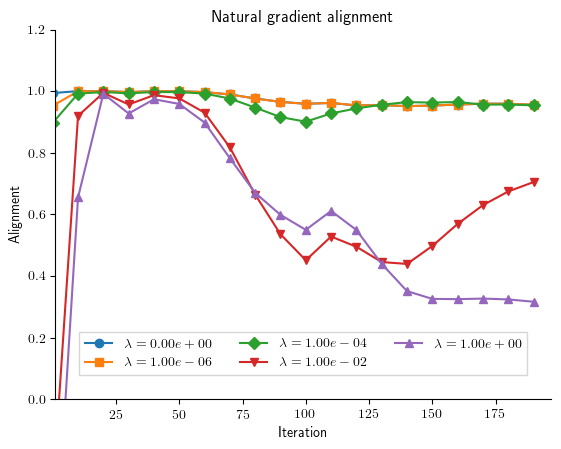

In [27]:

markers = ["o", "s", "D", "v", "^", "P", "X"]
for i, eps in enumerate(eps_vals):
    plt.plot(iters[:], alignment[eps][:], marker=markers[i], label=f"$\lambda = {eps:.2e}$")
plt.xlim([1, 197])
plt.ylim([0, 1.2])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.2), ncol=3, fancybox=False, shadow=False)
plt.xlabel("Iteration")
plt.ylabel("Alignment")
plt.title("Natural gradient alignment")

plt.gcf().savefig("/home/emastr/phd/NaturalGradientTraining/experiments/alignment.pdf", bbox_inches="tight")